In [ ]:
# python collect_jobs_and_clean.py -d /home1/smaruj/akitaV2-analyses/experiments/TAD_boundaries_analysis/boundaries_disruption.tsv 
# -v -l /scratch1/smaruj/tad_disruption/model0_m0/

# python collect_jobs_and_clean.py -d /home1/smaruj/akitaV2-analyses/experiments/TAD_boundaries_analysis/boundaries_disruption_2.tsv 
# -v -l /scratch1/smaruj/tad_disruption/model0_2_m0/

In [1]:
import numpy as np
import pandas as pd
from akita_utils.format_io import h5_to_df
import bioframe as bf

In [2]:
df_1 = h5_to_df("/scratch1/smaruj/tad_disruption/model0_m0/STATS_OUT.h5", average=False)
df_2 = h5_to_df("/scratch1/smaruj/tad_disruption/model0_2_m0/STATS_OUT.h5", average=False)

In [ ]:
# target 1 is Bonev ES Cells, which HiC TAD boundaries have called on

In [3]:
df = pd.concat([df_1, df_2], axis=0, ignore_index=True)

In [4]:
type_order = ['down5', 'down4', 'down3', 'down2', 'down1', 'tad1', 'tad2', 'tad3', 'tad4', 'tad5', 'up1', 'up2', 'up3', 'up4', 'up5']

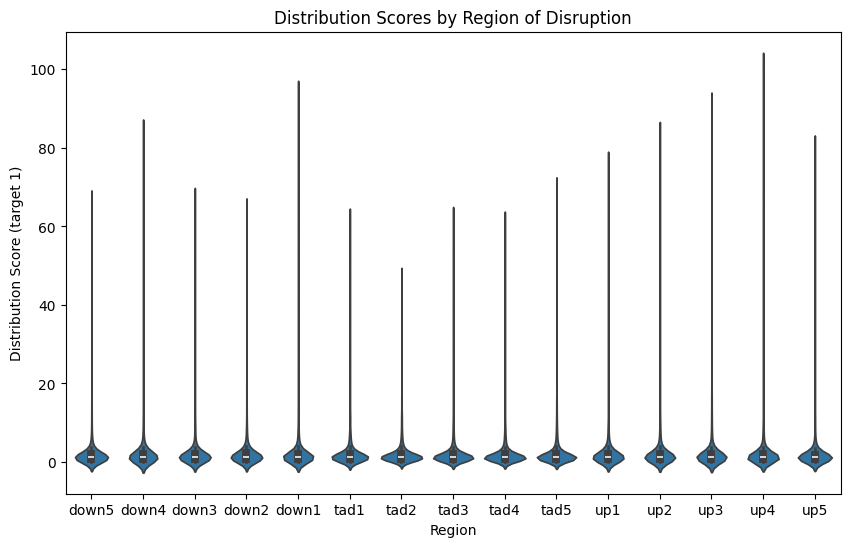

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(10, 6))

# Create the violin plot
sns.violinplot(data=df, x='type', y='SCD_h1_m0_t1', inner='box', order=type_order)

# Add labels and title
plt.xlabel('Region')
plt.ylabel('Distribution Score (target 1)')
plt.title('Distribution Scores by Region of Disruption')

# Show the plot
plt.show()

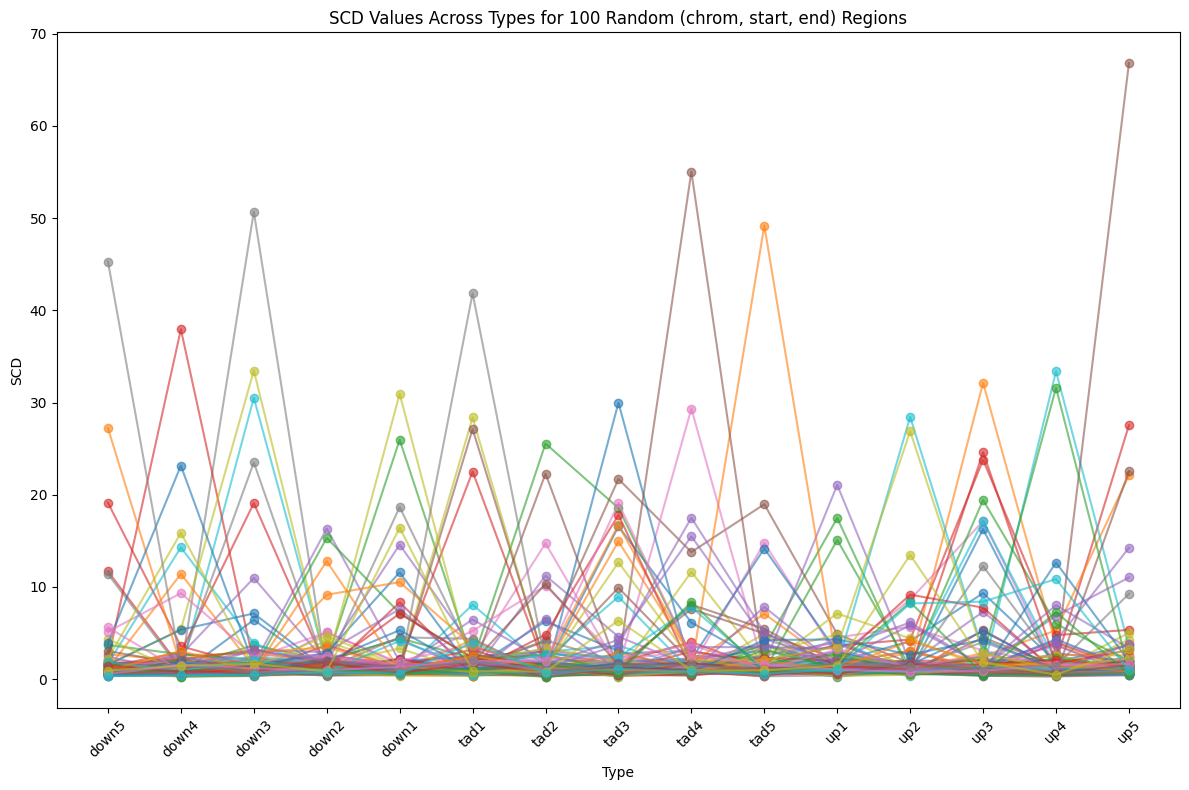

In [6]:
# Randomly sample 100 unique (chrom, start, end) regions
sampled_df = df.drop_duplicates(subset=['chrom', 'start', 'end']).sample(n=100)

# Filter the original dataframe to include only the sampled regions
filtered_df = df[df[['chrom', 'start', 'end']].apply(tuple, axis=1).isin(sampled_df[['chrom', 'start', 'end']].apply(tuple, axis=1))]

# Set up the figure
plt.figure(figsize=(12, 8))

# Define the order for the types
type_order = ['down5', 'down4', 'down3', 'down2', 'down1', 'tad1', 'tad2', 'tad3', 'tad4', 'tad5', 'up1', 'up2', 'up3', 'up4', 'up5']

# Create a mapping from type to order
type_mapping = {t: i for i, t in enumerate(type_order)}

# For each sampled region, plot the line connecting SCD values for each type
for (chrom, start, end), group in filtered_df.groupby(['chrom', 'start', 'end']):
    # Sort the group by the defined type order
    group = group.sort_values(by='type', key=lambda x: x.map(type_mapping))
    plt.plot(group['type'], group['SCD_h1_m0_t1'], marker='o', label=f"{chrom}:{start}-{end}", alpha=0.6)

# Add labels and title
plt.xlabel('Type')
plt.ylabel('SCD')
plt.title('SCD Values Across Types for 100 Random (chrom, start, end) Regions')

# Optional: Add legend (can be overwhelming with 100 lines)
# plt.legend(loc='best')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()


In [7]:
# Filter the dataframe for rows where SCD > 10
filtered_df = df[df['SCD_h1_m0_t1'] >= 10]

# Count unique (chrom, start, end) combinations
unique_regions_count = filtered_df[['chrom', 'start', 'end']].drop_duplicates().shape[0]

# Output the result
print(f"Number of unique (chrom, start, end) regions with SCD >= 10 for at least one type: {unique_regions_count}")


Number of unique (chrom, start, end) regions with SCD >= 10 for at least one type: 2386


In [8]:
# Group by (chrom, start, end) and check if all SCD_h1_m0_t1 scores are < 10
complementary_df = df.groupby(['chrom', 'start', 'end']).filter(lambda x: (x['SCD_h1_m0_t1'] < 10).all())

# Count unique (chrom, start, end) combinations in the complementary dataframe
unique_complementary_regions_count = complementary_df[['chrom', 'start', 'end']].drop_duplicates().shape[0]

# Output the result
print(f"Number of unique (chrom, start, end) regions with all SCD_h1_m0_t1 < 10: {unique_complementary_regions_count}")

Number of unique (chrom, start, end) regions with all SCD_h1_m0_t1 < 10: 1799


### Checking the TAD metrics (from the HiC data)

In [9]:
scores_df = pd.read_csv("./boundaries_no_strong_site.tsv", sep="\t")

In [10]:
overlapped_df = bf.overlap(df, scores_df, suffixes=("", "_2"), return_index=False, how="left")
max_scd_df = overlapped_df.groupby(by=["chrom", "start", "end"])["SCD_h1_m0_t1"].max().reset_index()
mean_ins = overlapped_df.groupby(by=["chrom", "start", "end"])[["log2_insulation_score_200000_2", "n_valid_pixels_200000_2", "boundary_strength_200000_2"]].mean().reset_index()

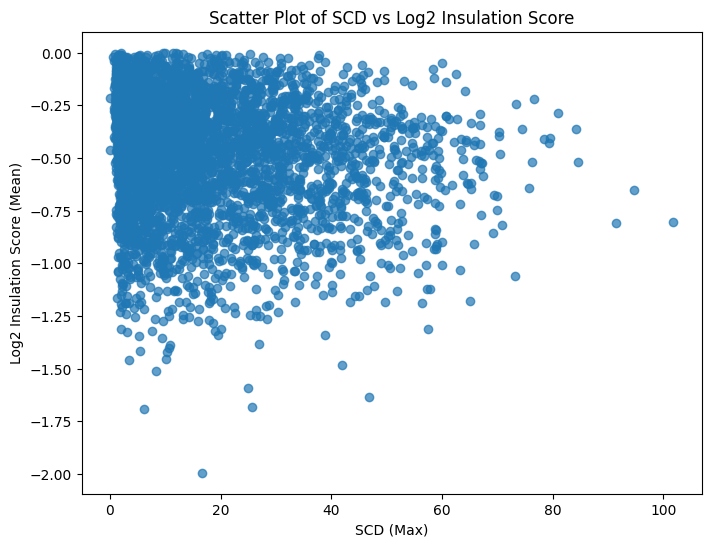

In [11]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(max_scd_df["SCD_h1_m0_t1"], mean_ins["log2_insulation_score_200000_2"], alpha=0.7)

# Add labels and title
plt.xlabel('SCD (Max)')
plt.ylabel('Log2 Insulation Score (Mean)')
plt.title('Scatter Plot of SCD vs Log2 Insulation Score')

# Show the plot
plt.show()

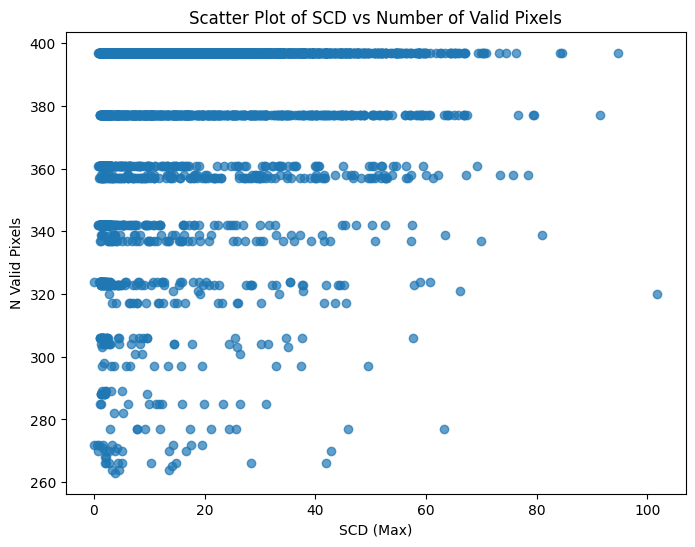

In [12]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(max_scd_df["SCD_h1_m0_t1"], mean_ins["n_valid_pixels_200000_2"], alpha=0.7)

# Add labels and title
plt.xlabel('SCD (Max)')
plt.ylabel('N Valid Pixels')
plt.title('Scatter Plot of SCD vs Number of Valid Pixels')

# Show the plot
plt.show()

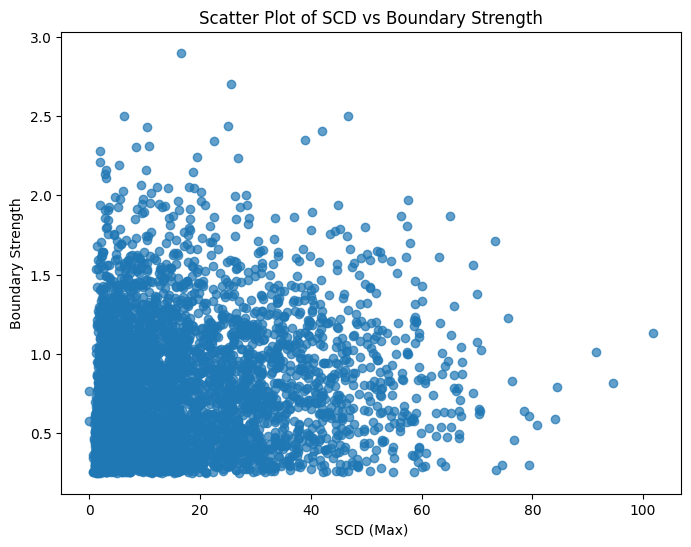

In [13]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(max_scd_df["SCD_h1_m0_t1"], mean_ins["boundary_strength_200000_2"], alpha=0.7)

# Add labels and title
plt.xlabel('SCD (Max)')
plt.ylabel('Boundary Strength')
plt.title('Scatter Plot of SCD vs Boundary Strength')

# Show the plot
plt.show()

### Sampling TAD boundaries for visualization purposes

In [14]:
max_SCD_df = filtered_df.groupby(['chrom', 'start', 'end', 'type', 
                                  'rel_disruption_end', 'rel_disruption_start',
                                  'window_end', 'window_start'])["SCD_h1_m0_t1"].max().reset_index()

In [15]:
max_indices = max_SCD_df.groupby(['chrom', 'start', 'end'])['SCD_h1_m0_t1'].idxmax()

In [16]:
unique_max_scd_df = max_SCD_df.loc[max_indices].reset_index(drop=True)

In [17]:
# Define the bins and labels for the SCD_h1_m0_t0 ranges
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-inf']

In [18]:
# Add a new column 'SCD_range' that assigns each row to a bin
unique_max_scd_df['SCD_range'] = pd.cut(unique_max_scd_df['SCD_h1_m0_t1'], bins=bins, labels=labels, right=False)

In [19]:
# Sample 10 rows from each SCD_range bin
sampled_df = unique_max_scd_df.groupby('SCD_range').apply(lambda x: x.sample(min(len(x), 10), random_state=42)).reset_index(drop=True)

/tmp/SLURM_24061820/ipykernel_60273/3855562313.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_df = unique_max_scd_df.groupby('SCD_range').apply(lambda x: x.sample(min(len(x), 10), random_state=42)).reset_index(drop=True)


In [ ]:
# sampled_df

In [ ]:
# sampled_df.to_csv("sampled_explained.tsv", sep="\t")

In [20]:
sampled_unexplained = complementary_df[['chrom', 'start', 'end',
                                        'type', 'rel_disruption_end', 'rel_disruption_start',
                                        'window_end', 'window_start', 'SCD_h1_m0_t1']].drop_duplicates().sample(n=50).reset_index(drop=True)

In [ ]:
# sampled_unexplained

In [21]:
all_unexplained = complementary_df[['chrom', 'start', 'end', 'window_end', 'window_start']].drop_duplicates()

In [ ]:
# sampled_unexplained.to_csv("sampled_unexplained.tsv", sep="\t")

In [ ]:
# all_unexplained.to_csv("all_unexplained_windows.tsv", sep="\t")

### Checking orientation for the up and down boundaries

In [22]:
unique_max_scd_df = unique_max_scd_df.rename(columns={"start": "TAD_start", "end": "TAD_end"})

In [23]:
unique_max_scd_df["start"] = unique_max_scd_df["window_start"] + unique_max_scd_df["rel_disruption_start"]
unique_max_scd_df["end"] = unique_max_scd_df["window_start"] + unique_max_scd_df["rel_disruption_end"]

In [ ]:
# unique_max_scd_df

In [ ]:
# down_maximum = unique_max_scd_df[(unique_max_scd_df["type"] == "down1") | (unique_max_scd_df["type"] == "down2") | \
#     (unique_max_scd_df["type"] == "down3") | (unique_max_scd_df["type"] == "down4") | (unique_max_scd_df["type"] == "down5")]

# up_maximum = unique_max_scd_df[(unique_max_scd_df["type"] == "up1") | (unique_max_scd_df["type"] == "up2") | \
#     (unique_max_scd_df["type"] == "up3") | (unique_max_scd_df["type"] == "up4") | (unique_max_scd_df["type"] == "up5")]


In [24]:
from akita_utils.df_utils import filter_by_chromID

In [25]:
jaspar_file = "/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz"
chrom_sizes_file = "/project/fudenber_735/genomes/mm10/mm10.chrom.sizes.reduced"
autosomes_only = True

In [26]:
if autosomes_only:
    chromID_to_drop = ["chrX", "chrY", "chrM"]
    
# read jaspar table (all CTCFs in the mouse genome)
jaspar_df = bf.read_table(jaspar_file, schema="jaspar", skiprows=1)
if autosomes_only:
    jaspar_df = filter_by_chromID(jaspar_df, chrID_to_drop=chromID_to_drop)
jaspar_df.reset_index(drop=True, inplace=True)

In [27]:
orient_df_overlap = bf.overlap(unique_max_scd_df, jaspar_df, suffixes=("", "_2"), return_index=False, how="inner")

In [28]:
orient_df_overlap['strand_2'] = orient_df_overlap['strand_2'].replace({'+': '>', '-': '<'})

In [29]:
overlap_strand = orient_df_overlap.groupby(['chrom', 'start', 'end', 'type']).agg({
    'strand_2': lambda x: ''.join(x),   # Concatenate 'type' values
}).reset_index()

In [30]:
# Function to replace less frequent values with 'others'
def process_strand(df, column, group_col, top_n=5):
    top_values = df.groupby(group_col)[column].apply(lambda x: x.value_counts().nlargest(top_n).index)
    top_values = top_values.explode().reset_index()
    
    def label_others(row):
        if row[column] in top_values[top_values[group_col] == row[group_col]][column].values:
            return row[column]
        else:
            return 'others'
    
    df['strand_processed'] = df.apply(label_others, axis=1)
    return df

In [31]:
# Apply the function to process strand_2
df_processed = process_strand(overlap_strand, 'strand_2', 'type', top_n=2)

In [32]:
def assign_color(value):
    if value == ">":
        return 'green'
    elif value == ">>":
        return 'darkgreen'
    elif value == "<":
        return 'purple'
    elif value == "<<":
        return 'darkmagenta'
    else:
        return 'silver'  # just in case for any unknown

# Create a dictionary of colors for strand_2 values
unique_strands = df_processed['strand_processed'].unique()
color_palette = {strand: assign_color(strand) for strand in unique_strands}

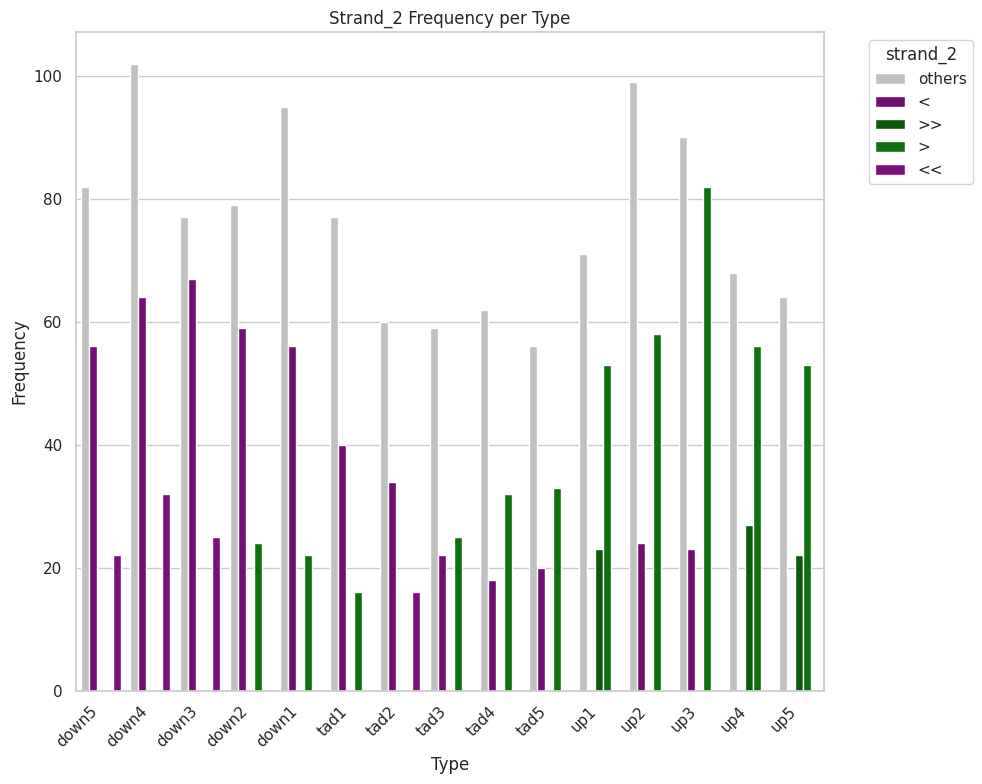

In [33]:
# Adjust the plot with the new color scheme
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Create stacked bar plot with hue and horizontal orientation, using custom palette
plot = sns.countplot(data=df_processed, x='type', hue='strand_processed', order=type_order, 
                     palette=color_palette, dodge=True)

# Set the labels and title
plot.set_title('Strand_2 Frequency per Type')
plot.set_ylabel('Frequency')
plot.set_xlabel('Type')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust legend and display the plot
plt.legend(title='strand_2', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [34]:
# grouping into 2 categories

overlap_strand['strand_category'] = overlap_strand['strand_2'].replace({'<<': '<', '<': '<', '>': '>', '>>': '>'})

In [35]:
categories_2 = overlap_strand[(overlap_strand["strand_category"] == "<") | (overlap_strand["strand_category"] == ">")]

In [36]:
counts = categories_2.groupby(['type', 'strand_category']).size().unstack(fill_value=0)

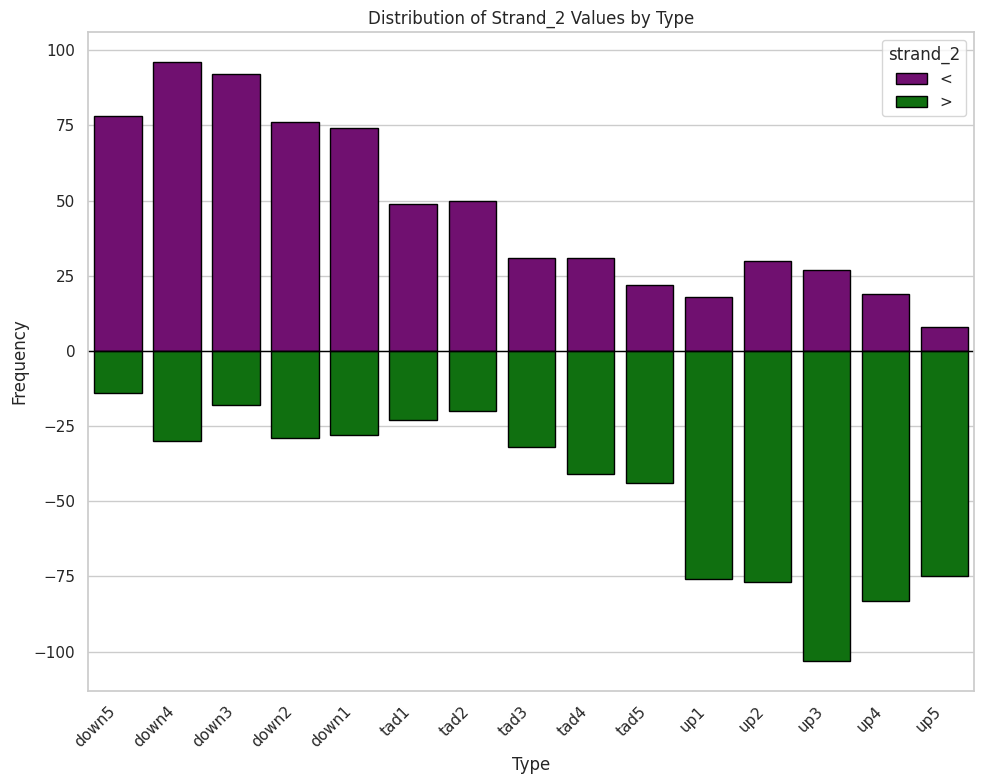

In [39]:
# Prepare plot with two distributions: "<" above x-axis and ">" below
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Define the desired order for the types
type_order = ['down5', 'down4', 'down3', 'down2', 'down1', 'tad1', 'tad2', 'tad3', 'tad4', 'tad5', 'up1', 'up2', 'up3', 'up4', 'up5']

# Plot the "<" distribution with the specified order
sns.barplot(x=counts.index, y=counts['<'], color='purple', label='<', edgecolor='black', order=type_order)

# Plot the ">" distribution (negative values for mirrored plot) with the same order
sns.barplot(x=counts.index, y=-counts['>'], color='green', label='>', edgecolor='black', order=type_order)

# Set labels and title
plt.title('Distribution of Strand_2 Values by Type')
plt.xlabel('Type')
plt.ylabel('Frequency')

# Add a horizontal line at y=0 for separation
plt.axhline(0, color='black', linewidth=1)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend and display the plot
plt.legend(title='strand_2')
plt.tight_layout()
plt.show()

In [ ]:
down_frequencies = down_strand['strand_2'].value_counts()

In [ ]:

plt.figure(figsize=(10, 6))
down_frequencies.plot(kind='bar', color='skyblue')

# Customize plot
plt.title(f'Frequency of Orientations with the disruption-sensitive bins in the DOWNSTREAM, n={len(down_strand)}')
plt.xlabel('Concatenated Strands')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
up_df_overlap = bf.overlap(up_maximum, jaspar_df, suffixes=("", "_2"), return_index=False, how="inner")

In [ ]:
up_strand = up_df_overlap.groupby(['chrom', 'start', 'end']).agg({
    'strand_2': lambda x: ', '.join(x),   # Concatenate 'type' values with commas
}).reset_index()

In [ ]:
up_frequencies = up_strand['strand_2'].value_counts()

In [ ]:

plt.figure(figsize=(10, 6))
up_frequencies.plot(kind='bar', color='skyblue')

# Customize plot
plt.title(f'Frequency of Orientations with the disruption-sensitive bins in the UPTREAM, n={len(up_strand)}')
plt.xlabel('Concatenated Strands')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show plot
plt.show()